# How to simulate open system dynamics
**Calculating the dynamics of a quantum system described by a GKS–Lindblad master equation**

Boulder Opal enables you to simulate not only the evolution of isolated quantum systems with and without noise, but also the evolution of systems that are interacting with their environment. 
You can express the dynamics of these open quantum systems in terms of a master equation, such as the one described by [Gorini, Kossakowski, and Sudarshan (GKS)](https://doi.org/10.1063/1.522979) and [Lindblad](https://doi.org/10.1007/BF01608499): 

$$ \frac{\mathrm{d} \rho(t)}{\mathrm{d} t} = - i \left[ H_{\rm s}(t), \rho(t) \right] + \sum_i \gamma_i \left[ L_i \rho(t) L_i^\dagger - \frac{1}{2} \rho(t) L_i^\dagger L_i - \frac{1}{2} L_i^\dagger L_i  \rho(t) \right]. $$

This equation describes the evolution of a system that obeys a system Hamiltonian $H_{\rm s}$ and also any number of extra Lindbladian terms consisting of a rate $\gamma_i$ and a Lindblad operator $L_i$.

The GKS–Lindblad equation can be solved either exactly or to a specified tolerance using the `graph.density_matrix_evolution_pwc` node.
This node vectorizes the above equation, transforming the density matrix into a $D^2$-vector (where $D$ is the dimension of the Hilbert space) and evolves it in time using a $D^2\times D^2$ matrix.
Thus, solving the equation in this manner can be infeasible for large systems, especially if you are working with dense arrays.
A separate [user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-large-open-system-dynamics) covers efficient approaches for large systems.
Alternatively, a jump-based trajectory method can also be used.

The dynamics can be approximated with the trajectory method, exposed via the `graph.jump_trajectory_evolution_pwc` node. 
Here, instead of evolving the density matrix, a set of pure states $\{|\psi_a(t)\rangle\}$  which are subject to stochastic jumps 
$$|\psi_a(t)\rangle \rightarrow \frac{L_i|\psi_a(t)\rangle}{\sqrt{\langle \psi_a(t)|L_i^\dagger L_i|\psi_a(t)\rangle}}$$
are evolved.
The density matrix can then be approximated as
$$\rho(t) \approx \frac{1}{N_\text{traj}} \sum_{a=1}^{N_\text{traj}} |\psi_a(t)\rangle\langle \psi_a(t)| $$
where $N_\text{traj}$ is the number of trajectories.
In the limit $N_\text{traj} \rightarrow \infty$ we get the exact dynamics.
Thus instead of solving for a $D^2\times D^2$ generator, we are here simulating $N_\text{traj}$ states evolving under a $D\times D$ Hamiltonian. 
Hence for large systems this approach is much less memory intensive than the aforementioned method, allowing one to probe the dynamics of larger systems.

The tools described in this notebook allow you to solve this GKS–Lindblad master equation to obtain the time evolution for the system that you want.

## Summary workflow

### 1. Define Lindblad terms in computational graph
To describe the dynamics of an open system with Boulder Opal, you start by setting up a graph object as described in the [How to represent quantum systems using graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs) user guide. 
The difference is that besides setting up a graph with a piecewise-constant system `hamiltonian` $H_{\rm s} (t)$ for the controls, you must also define the Lindblad terms that appear in the GKS–Lindblad master equation above.
The `lindblad_terms` must be a tuple or list of tuples each containing a rate $\gamma_i$ and a Lindblad operator $L_i$.

### 2. Calculate density matrix evolution
Pass the piecewise constant `hamiltonian` and `lindblad_terms` to either `graph.density_matrix_evolution_pwc` or `graph.jump_trajectory_evolution_pwc` to calculate the evolved density matrices.
For the `graph.density_matrix_evolution_pwc` node an `initial_density_matrix` must be passed, while for the `graph.jump_trajectory_evolution_pwc` node an `initial_state_vector` must be passed. 
A `max_time_step` (which affects how accurately the jump processes are sampled) must also be passed to the `graph.jump_trajectory_evolution_pwc` node.

To obtain the density matrix $\rho(t)$ for a range of times, pass a value for the `sample_times`.
If omitted only the evolved density matrix at the final time of the system Hamiltonian is returned

## Example: Simulating a single-qubit open system

For this example, consider a single-qubit system whose evolution you can control through a complex Rabi rate $\Omega(t)$ and a detuning $\Delta(t)$, so that the system Hamiltonian is:

$$ H_{\rm s}(t) = \frac{1}{2} \left( \Omega(t) \sigma_- + \Omega^* (t) \sigma_+ \right) + \Delta(t) \sigma_z, $$

where $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the Pauli matrices and $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$.
Suppose this system is also subject to $T_2$ noise, which you can represent by the Lindblad operator $L= \sigma_z$ with associated rate $\gamma = 1/(2T_2)$. 

The master equation integration tool from Boulder Opal allows you to obtain the solution of a GKS–Lindblad equation:

$$ 
\frac{\mathrm{d} \rho(t)}{\mathrm{d} t} = - i \left[ H_{\rm s} (t), \rho(t) \right] + \gamma  \left[ \sigma_z \rho(t) \sigma_z - \rho(t) \right].\\
$$

By using the tools from Boulder Opal to solve this master equation, you can obtain the evolution of the system in terms of $\rho(t)$.

The first step is to set up the Python object that represents the pulse, which you can define by yourself or by importing one of the predefined pulses in the [Q-CTRL Open Controls](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls) package.
In particular, this example illustrates the case where the target operation is an $X_{\pi}$ rotation applied to a system initially at the state $\left|0\right\rangle$, which corresponds to the initial density matrix $\rho(0) = \left| 0 \right\rangle \left\langle 0 \right|$.
Such an operation should flip the qubit from the state $\left|0\right\rangle$ to the state $\left|1\right\rangle$, however this will be disrupted by the presence of $T_2$ noise.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlopencontrols as oc
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define control parameters.
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi

# Obtain predefined pulse from Q-CTRL Open Controls.
predefined_pulse = oc.new_primitive_control(
    rabi_rotation=total_rotation, azimuthal_angle=0.0, maximum_rabi_rate=omega_max
)

# Define time parameters of the simulation.
duration = sum(predefined_pulse.durations)
sample_times = np.linspace(0, duration, 100)

# Create simulation graph.
graph = bo.Graph()

initial_state = graph.fock_state(2, 0)
initial_density_matrix = graph.outer_product(initial_state, initial_state)

# Define the controls using the predefined pulse.
omega = graph.pwc(
    values=predefined_pulse.rabi_rates * np.exp(1j * predefined_pulse.azimuthal_angles),
    durations=predefined_pulse.durations,
)
delta = graph.pwc(
    values=predefined_pulse.detunings, durations=predefined_pulse.durations
)

# Define terms of the Hamiltonian.
sigma_x_term = graph.hermitian_part(omega * graph.pauli_matrix("M"))
sigma_z_term = delta * graph.pauli_matrix("Z")
hamiltonian = sigma_x_term + sigma_z_term

# Calculate vector state evolution for a closed system.
graph.matmul(
    graph.time_evolution_operators_pwc(hamiltonian, sample_times),
    initial_state[:, None],
    name="closed_system_states",
)

# Define Lindblad term of the master equation.
lindblad_operator = graph.pauli_matrix("Z")
T2 = 1e-6  # s

# Calculate density matrix evolution according to the master equation.
graph.density_matrix_evolution_pwc(
    initial_density_matrix=initial_density_matrix,
    hamiltonian=hamiltonian,
    lindblad_terms=[(1 / (2 * T2), lindblad_operator)],
    sample_times=sample_times,
    name="density_matrices",
)

# Run simulation.
results = bo.execute_graph(
    graph=graph, output_node_names=["closed_system_states", "density_matrices"]
)

Your task (action_id="1829143") has started.
Your task (action_id="1829143") has completed.


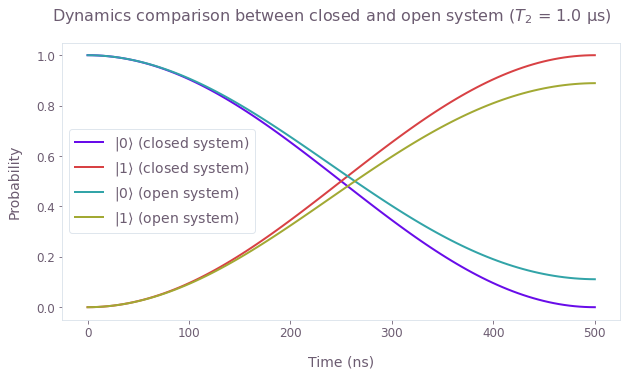

In [3]:
closed_system_populations = (
    np.abs(results["output"]["closed_system_states"]["value"][:, :, 0]) ** 2
)
open_system_populations = np.real_if_close(
    np.diagonal(results["output"]["density_matrices"]["value"], axis1=-1, axis2=-2)
)

qv.plot_population_dynamics(
    sample_times,
    {
        r"$|{0}\rangle$ (closed system)": closed_system_populations[:, 0],
        r"$|{1}\rangle$ (closed system)": closed_system_populations[:, 1],
        r"$|{0}\rangle$ (open system)": open_system_populations[:, 0],
        r"$|{1}\rangle$ (open system)": open_system_populations[:, 1],
    },
)
plt.suptitle(
    f"Dynamics comparison between closed and open system ($T_2$ = {T2*1e6} μs)"
)
plt.show()

## Example: Simulating the decoherence of a cat-state with the trajectory method

For this example, we consider a system initially in an even cat-state
$$|\psi(0)\rangle = N_+(|\alpha\rangle + |-\alpha\rangle) ,$$
where $N_+$ is a normalization factor and $|\alpha\rangle$ is a coherent state. 
The system has Hamiltonian
$$ H_{\rm s} = \omega a^\dagger a , $$
where $a$ ($a^\dagger$) is 
the annihilation (creation) operator, and is subject to dissipation via Lindblad operator $L=a$ with an associated rate of $\gamma$.
Thus the master equation is
$$ \frac{\mathrm{d} \rho(t)}{\mathrm{d} t} = - i \omega \left[ a^\dagger a, \rho(t) \right] + \gamma [ a \rho(t) a^\dagger - \frac{1}{2} \rho(t) a^\dagger a - \frac{1}{2} a^\dagger a  \rho(t)]. $$

Again we use the tools from Boulder Opal to solve this master equation, although this time we use the trajectory method.
We obtain the evolution of the system in terms of $\rho(t)$ and find that the number operator mean decays approximately as
$$ \mathrm{Tr}[\rho(t) a^\dagger a] \approx |\alpha|^2 e^{-\gamma t} .$$

In [4]:
dimension = 15  # The dimension of the Hilbert space.

duration = 300 * 1e-9  # s
sample_times = np.linspace(0.0, duration, 10)

graph = bo.Graph()

# Create the initial cat-state.
alpha = 2.4
initial_state = graph.coherent_state(alpha, dimension) + graph.coherent_state(
    -alpha, dimension
)
# Normalize the state.
initial_state = initial_state / graph.sqrt(
    graph.inner_product(initial_state, initial_state)
)

# Create the system Hamiltonian.
omega = 2 * np.pi * 1e6  # Hz
hamiltonian = graph.constant_pwc_operator(
    duration, omega * graph.number_operator(dimension)
)

# Define Lindblad term of the master equation.
lindblad_operator = graph.annihilation_operator(dimension)
gamma = 5e6  # Hz

evolved_density_matrices = graph.jump_trajectory_evolution_pwc(
    initial_state_vector=initial_state,
    hamiltonian=hamiltonian,
    lindblad_terms=[(gamma, lindblad_operator)],
    sample_times=sample_times,
    max_time_step=duration * 1e-3,
    trajectory_count=50,
)

# Return the initial density matrix.
initial_density_matrix = evolved_density_matrices[0]
initial_density_matrix.name = "initial_density_matrix"

# Return the final density matrix.
final_density_matrix = evolved_density_matrices[-1]
final_density_matrix.name = "final_density_matrix"

# Compute the expectation values of the number operator.
graph.density_matrix_expectation_value(
    evolved_density_matrices, graph.number_operator(dimension), name="number_operator"
)

results = bo.execute_graph(
    graph, ["number_operator", "initial_density_matrix", "final_density_matrix"]
)

Your task (action_id="1829144") has started.
Your task (action_id="1829144") has completed.


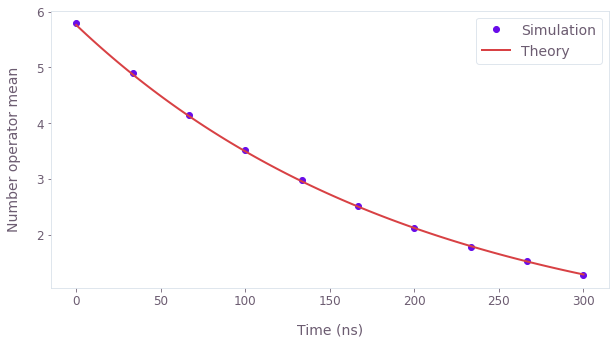

In [5]:
plt.plot(
    sample_times * 1e9,
    results["output"]["number_operator"]["value"].real,
    "o",
    label="Simulation",
)

fine_times = np.linspace(0.0, sample_times[-1], 100)
plt.plot(
    fine_times * 1e9,
    np.conj(alpha) * alpha * np.exp(-gamma * fine_times),
    label="Theory",
)

plt.ylabel("Number operator mean")
plt.xlabel("Time (ns)")
plt.legend()

plt.show()

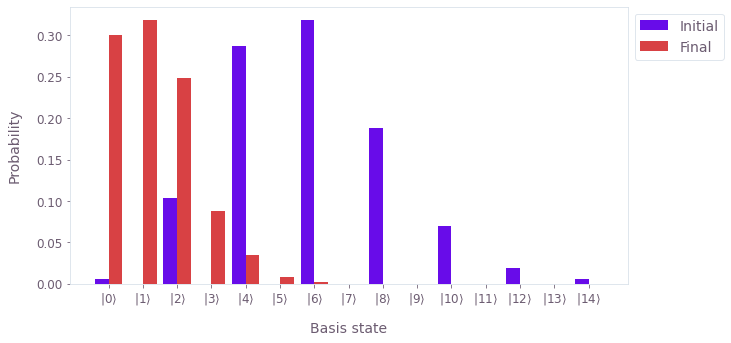

In [6]:
populations = {
    "Initial": np.diag(results["output"]["initial_density_matrix"]["value"]).real,
    "Final": np.diag(results["output"]["final_density_matrix"]["value"]).real,
}

qv.plot_population_distributions(populations)

### Summary

The open-system tools from Boulder Opal allow you to use the graph framework to calculate more general types of system evolution.
While the tools described in [this user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-quantum-dynamics-subject-to-noise-with-graphs) show how you can obtain the evolution of a system that follows the Schrödinger equation, the open system tools allow you to solve a more general master equation.
You can also use these tools in optimization graphs, if you have a cost function that represents what you want to optimize.